# Question 1

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import torch.distributions as dist

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

In [5]:
import pyro
import torch
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive
import pyro.distributions as dist
import pyro.optim as optim
from jax import random
# define the logistic regression model
def logistic_regression(x_data, y_data=None):
    # define the weights and bias
    weights = pyro.sample("weights", dist.Normal(torch.zeros(x_data.shape[1]), torch.ones(x_data.shape[1])).to_event(1))
    bias = pyro.sample("bias", dist.Normal(0., 10.))
    # define the linear function
    linear = torch.matmul(x_data, weights) + bias
    # define the sigmoid function
    sigmoid = torch.sigmoid(linear)
    # define the Bernoulli distribution
    with pyro.plate("data", x_data.shape[0]):
        obs = pyro.sample("obs", dist.Bernoulli(sigmoid), obs=y_data)
    return obs

# define the data
X = torch.tensor(X_train, dtype=torch.float)
y = torch.tensor(y_train, dtype=torch.float)

# run the model using NUTS MCMC sampling
nuts_kernel = NUTS(logistic_regression)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
# rng_key = random.PRNGKey(0)
mcmc.run(x_data=X, y_data=y)
samples = mcmc.get_samples()

/Users/arunreddy/opt/anaconda3/envs/PML/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sample: 100%|██████████| 1500/1500 [00:09, 154.80it/s, step size=6.38e-01, acc. prob=0.918]


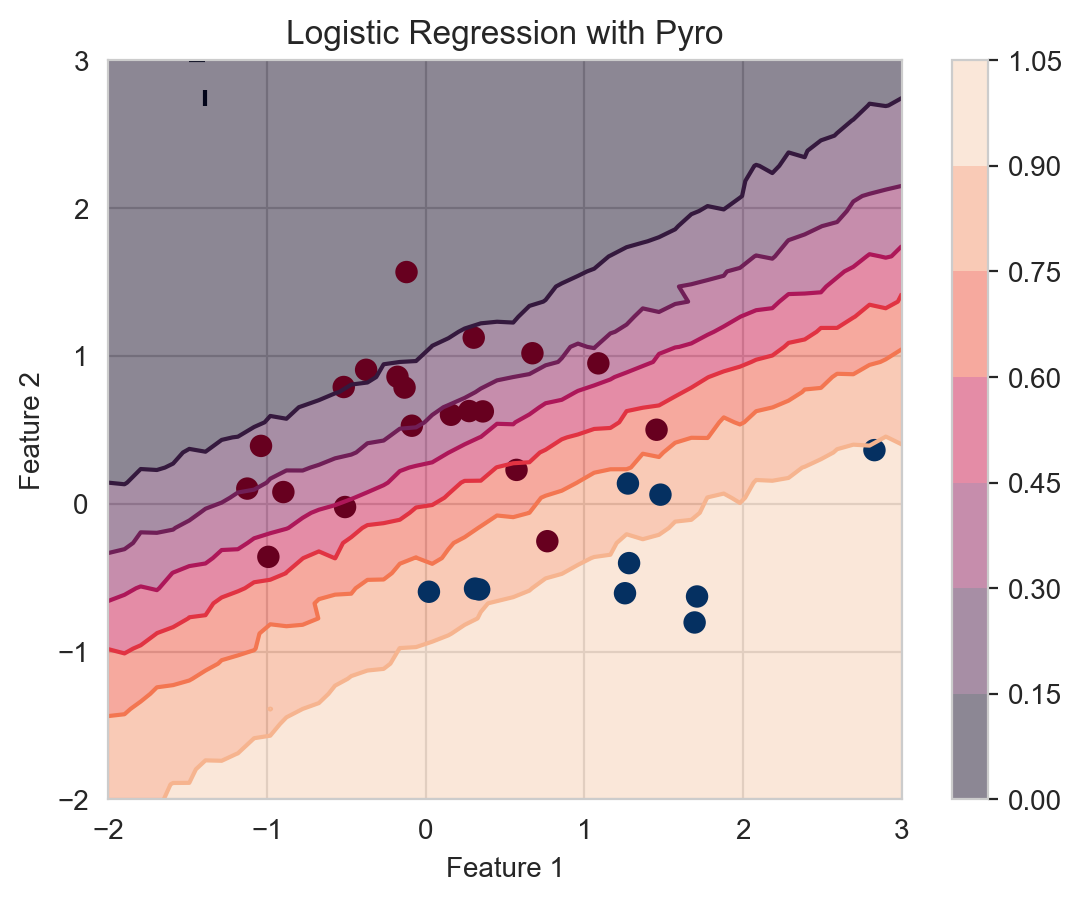

In [6]:
# define the test data
X_test = torch.tensor(X_test, dtype=torch.float)

# define the predictive distribution
predictive = Predictive(logistic_regression, samples)

# get the mean and standard deviation of the predictions over the 2d grid
x1, x2 = np.meshgrid(np.linspace(-2, 3, 50), np.linspace(-2, 3, 50))
X_new = torch.tensor(np.c_[x1.ravel(), x2.ravel()], dtype=torch.float)
y_pred = predictive(X_new)['obs'].mean(0)
y_std = predictive(X_new)['obs'].std(0)

# plot the mean prediction as well as standard deviation in the predictions over the 2d grid
c=plt.contourf(x1, x2, y_pred.reshape(x1.shape), alpha=0.5)
plt.contour(x1, x2, y_pred.reshape(x1.shape))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='RdBu')
#also plot the colorbar for the probability
plt.colorbar(c)
# plt.errorbar(X_new[:, 0], X_new[:, 1], yerr=y_std, fmt='none', c='k', alpha=0.5)
plt.title('Logistic Regression with Pyro')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


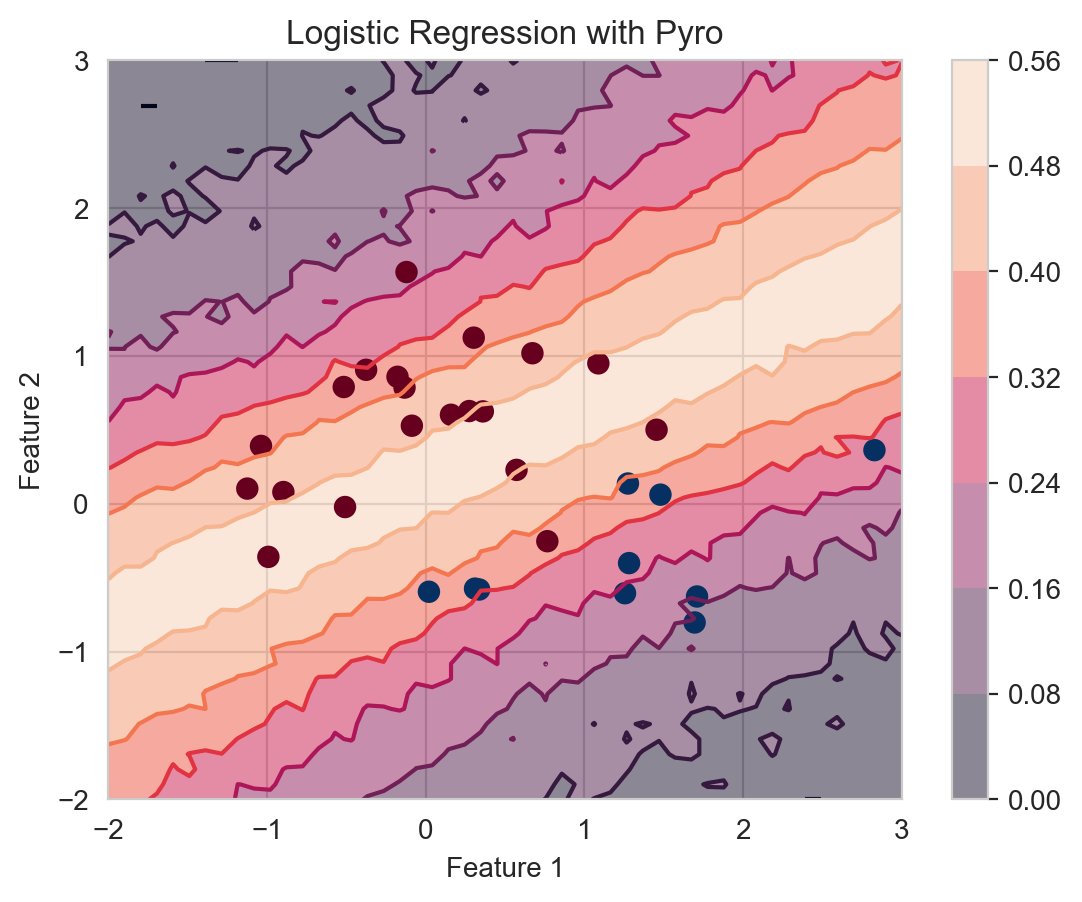

In [7]:
#plot a seperate figure for standard deviation
c2=plt.contourf(x1, x2, y_std.reshape(x1.shape), alpha=0.5)
plt.contour(x1, x2, y_std.reshape(x1.shape))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='RdBu')
plt.colorbar(c2)
plt.title('Logistic Regression with Pyro')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


# Question 2

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
from jax import random

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.constrained_layout.use'] = True

In [9]:
import graphviz

In [10]:
import seaborn as sns
sns.set_context("notebook")

In [11]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
train.head()

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

In [12]:
train.describe()

Weeks          FVC      Percent          Age
count  1549.000000  1549.000000  1549.000000  1549.000000
mean     31.861846  2690.479019    77.672654    67.188509
std      23.247550   832.770959    19.823261     7.057395
min      -5.000000   827.000000    28.877577    49.000000
25%      12.000000  2109.000000    62.832700    63.000000
50%      28.000000  2641.000000    75.676937    68.000000
75%      47.000000  3171.000000    88.621065    72.000000
max     133.000000  6399.000000   153.145378    88.000000

In [13]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
train["patient_code"] = patient_encoder.fit_transform(train["Patient"].values)

In [14]:
X = train.drop(columns=["Patient", "FVC", "Percent", "Age", "Sex", "SmokingStatus"])
y = train["FVC"]

In [15]:
# import train test split
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [17]:
sample_patient_code_train = x_train["patient_code"].values
sample_patient_code_test = x_test["patient_code"].values
x_train = x_train["Weeks"]
x_test = x_test["Weeks"]
# convert to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [18]:
import numpyro
import numpyro.distributions as dist

### Vanilla Linear Regression

In [19]:
### Linear regression from scikit-learn
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train.reshape(-1, 1), y_train)

LinearRegression()

In [20]:
all_weeks = np.arange(-12, 134, 1)

Text(0, 0.5, 'FVC')

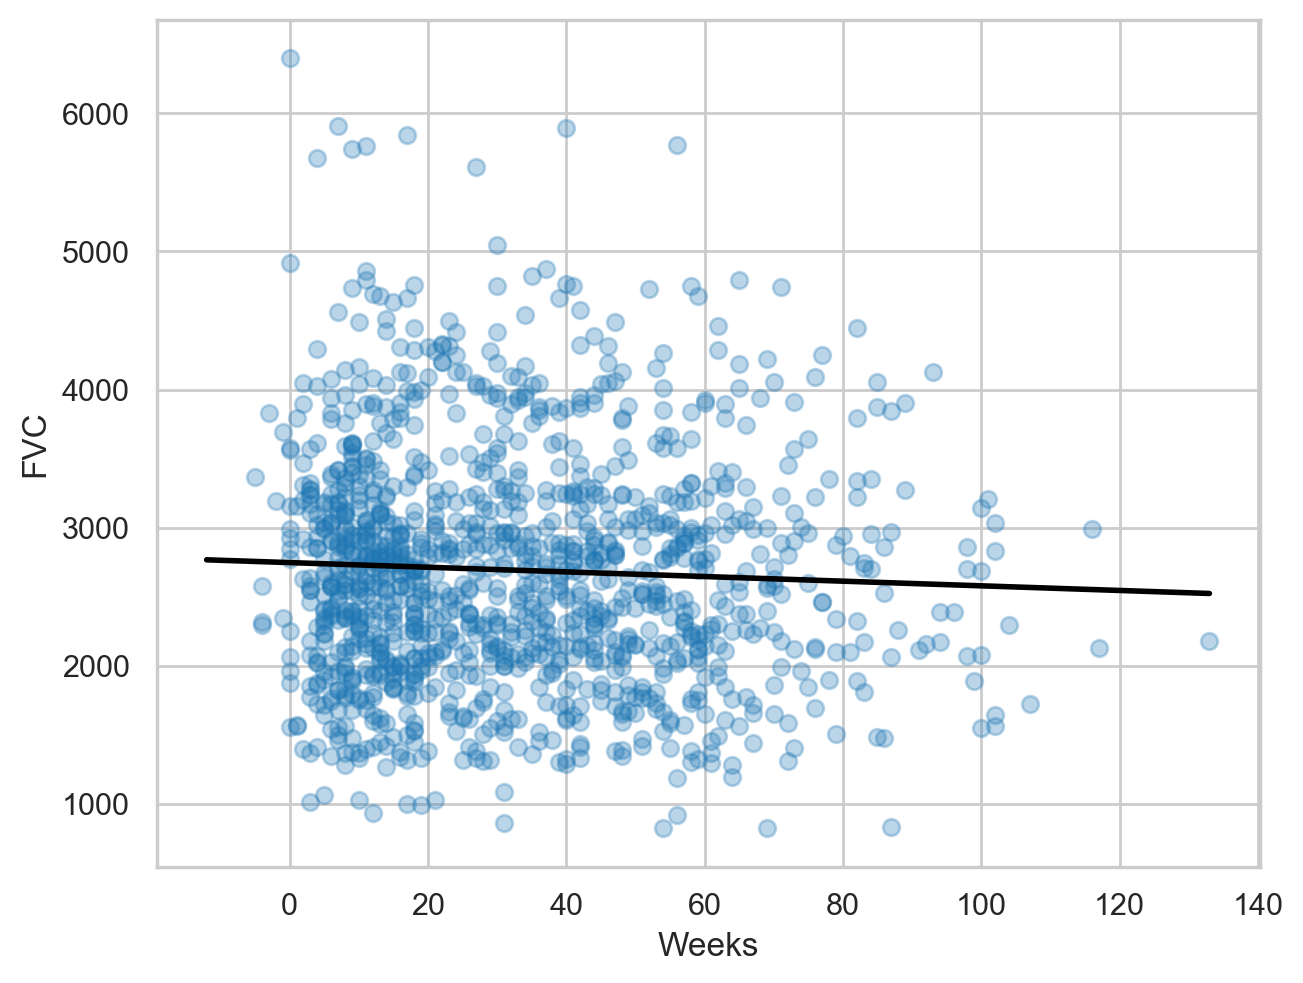

In [21]:
# Plot the data and the regression line
plt.scatter(x_train, y_train, alpha=0.3)
plt.plot(all_weeks, lr.predict(all_weeks.reshape(-1, 1)), color="black", lw=2)
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [22]:
lr.coef_, lr.intercept_

(array([-1.68051699]), 2747.966054074546)

In [23]:
# Finding the mean absolute error on train set

from sklearn.metrics import mean_absolute_error

maes = {}
maes["LinearRegression on train"] = mean_absolute_error(y_train, lr.predict(x_train.reshape(-1, 1)))
maes

{'LinearRegression on train': 662.1236659544445}

In [24]:
# Finding the mean absolute error on test set

from sklearn.metrics import mean_absolute_error


maes["LinearRegression on test"] = mean_absolute_error(y_test, lr.predict(x_test.reshape(-1, 1)))
maes

{'LinearRegression on train': 662.1236659544445,
 'LinearRegression on test': 626.3184730275215}

### Pooled model

$\alpha \sim \text{Normal}(0, 500)$

$\beta \sim \text{Normal}(0, 500)$

$\sigma \sim \text{HalfNormal}(100)$

`for i in range(N_Weeks):`

$FVC_i \sim \text{Normal}(\alpha + \beta \cdot Week_i, \sigma)$



In [25]:
sample_weeks = train["Weeks"].values
sample_fvc = train["FVC"].values

In [26]:
def pooled_model(sample_weeks, sample_fvc=None):
    α = numpyro.sample("α", dist.Normal(0., 500.))
    β = numpyro.sample("β", dist.Normal(0., 500.))
    σ = numpyro.sample("σ", dist.HalfNormal(50.))
    with numpyro.plate("samples", len(sample_weeks)):
        fvc = numpyro.sample("fvc", dist.Normal(α + β * sample_weeks, σ), obs=sample_fvc)
    return fvc

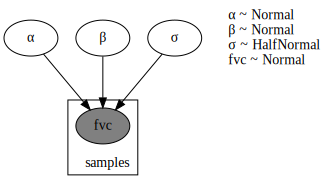

In [27]:
# Render the model graph
numpyro.render_model(pooled_model, model_kwargs={"sample_weeks": sample_weeks, "sample_fvc": sample_fvc},
                render_distributions=True,
                render_params=True,
                )

In [28]:
from numpyro.infer import MCMC, NUTS, Predictive

In [29]:
nuts_kernel = NUTS(pooled_model)

mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)

I0000 00:00:1699445840.827690       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [30]:
mcmc.run(rng_key, sample_weeks=x_train, sample_fvc=y_train)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 6000/6000 [00:02<00:00, 2086.06it/s, 7 steps of size 4.57e-01. acc. prob=0.91] 


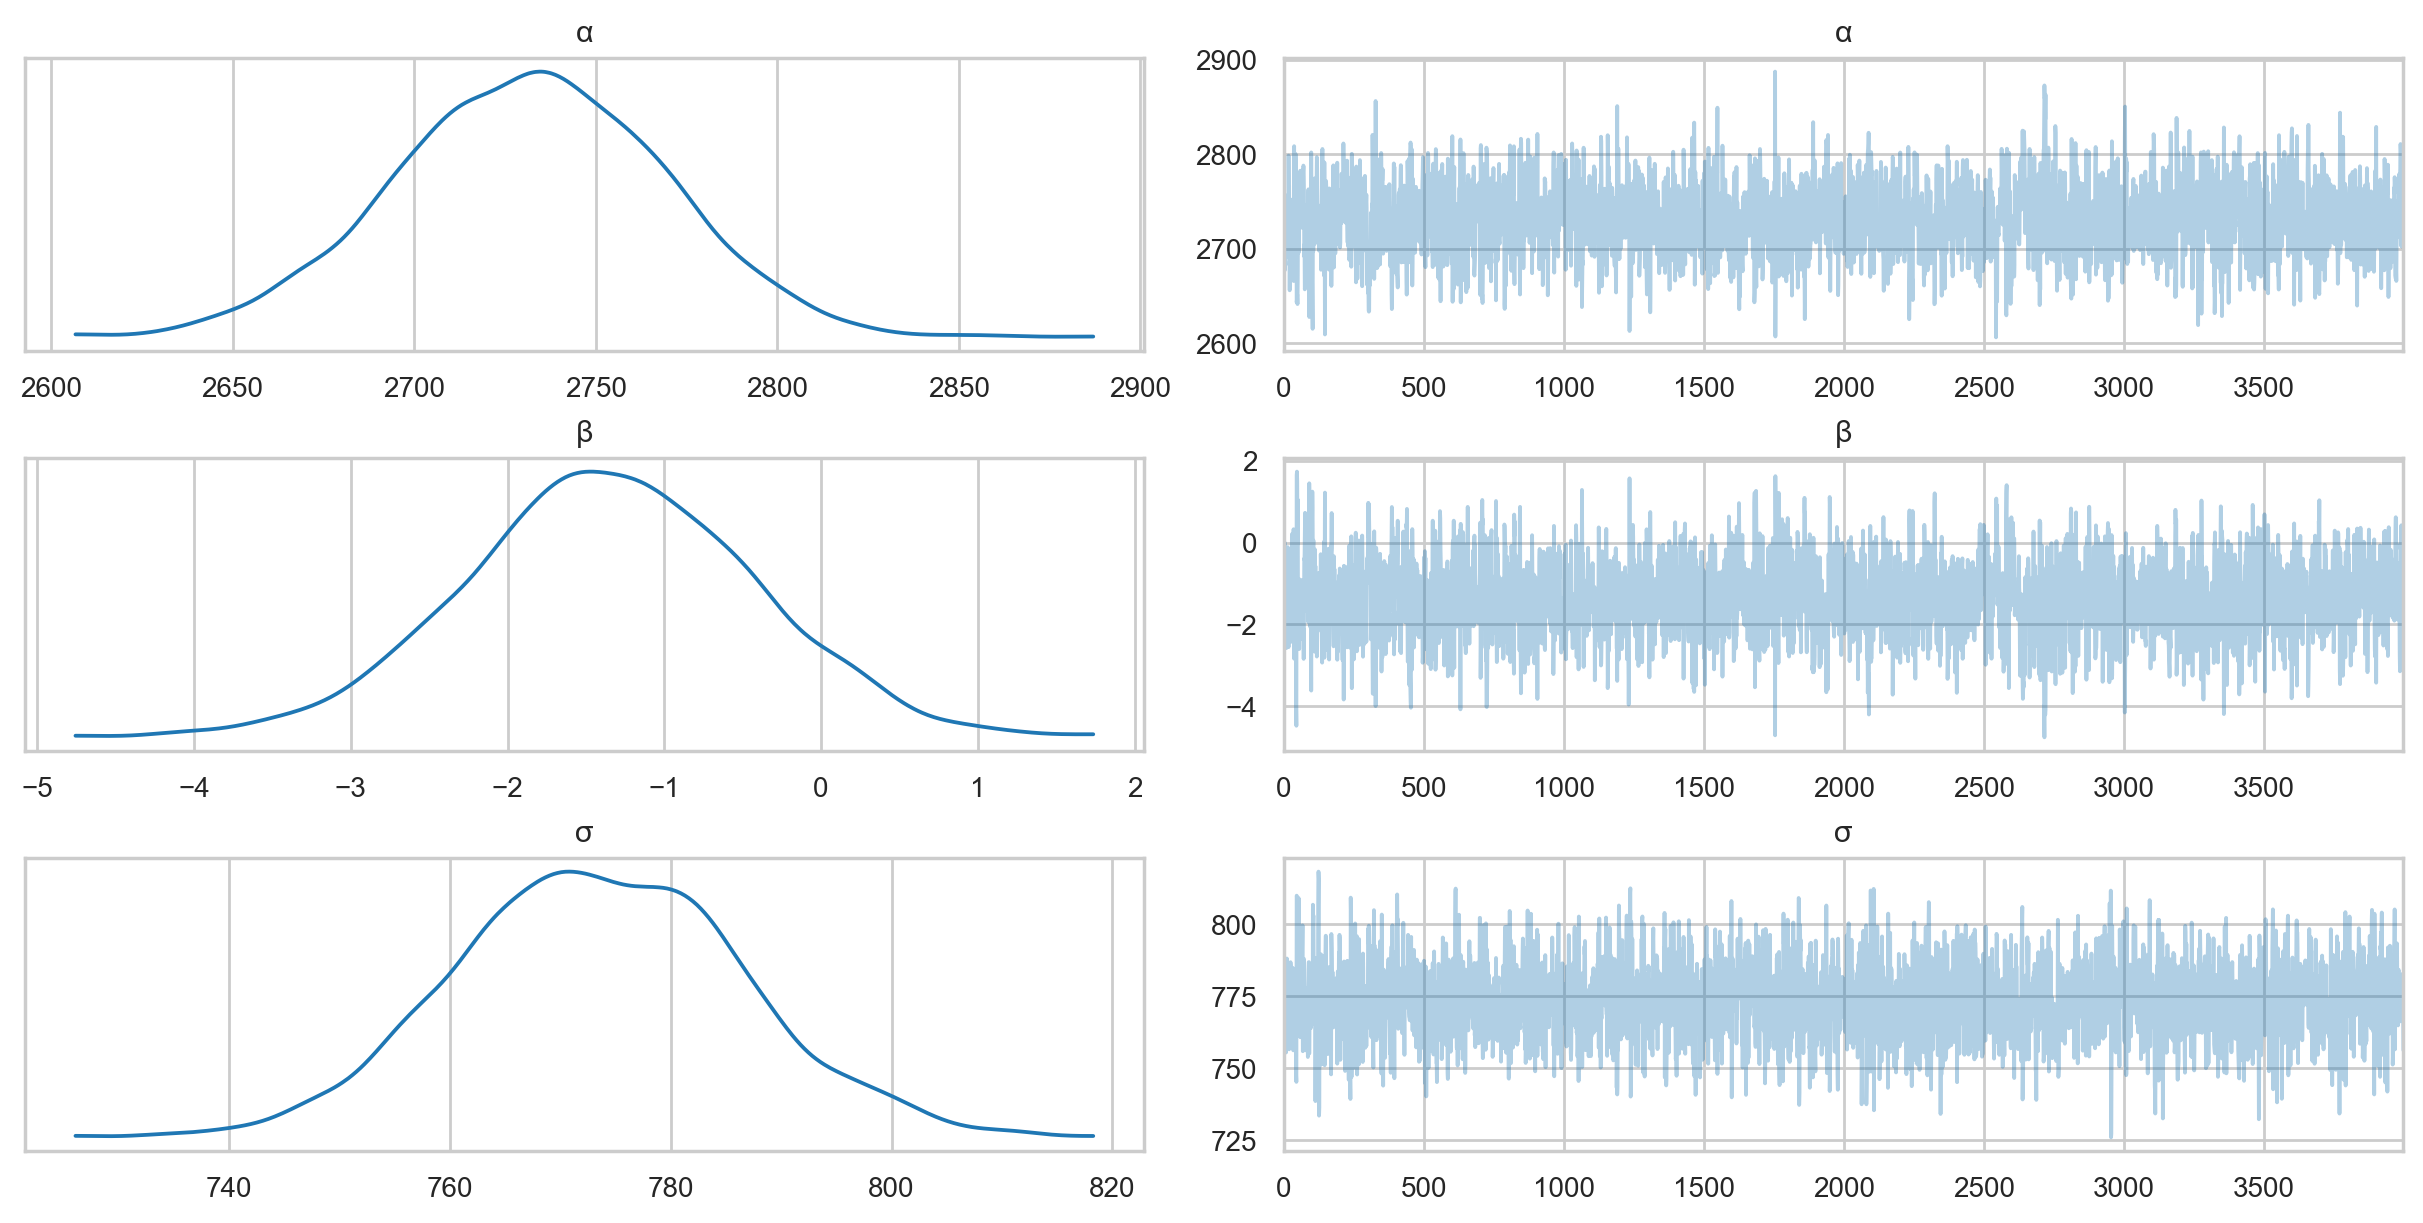

In [31]:
import arviz as az

idata = az.from_numpyro(mcmc)
az.plot_trace(idata, compact=True);

In [32]:
# Summary statistics
az.summary(idata, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α  2731.78  37.24  2658.75  2798.00       0.90     0.64   1713.98   1879.14   
β    -1.36   0.93    -3.01     0.44       0.02     0.02   1649.09   1842.16   
σ   773.41  12.98   750.62   799.75       0.25     0.18   2697.11   2607.93   

   r_hat  
α    NaN  
β    NaN  
σ    NaN

In [33]:
# Predictive distribution
predictive = Predictive(pooled_model, mcmc.get_samples())

In [34]:
predictions = predictive(rng_key, all_weeks, None)

Text(0, 0.5, 'FVC')

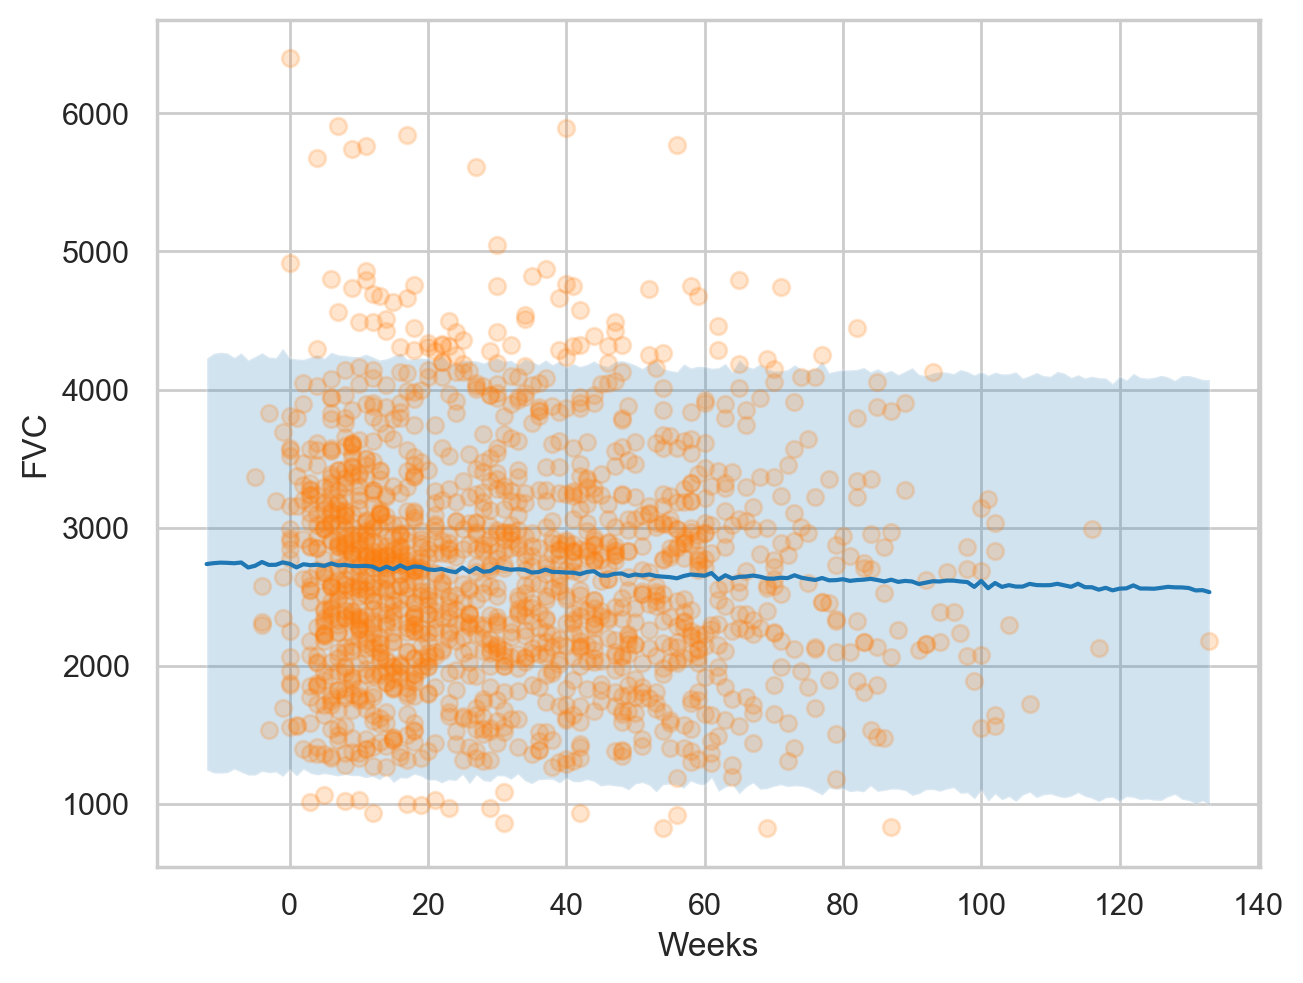

In [35]:
# Get the mean and standard deviation of the predictions
mu = predictions["fvc"].mean(axis=0)
sigma = predictions["fvc"].std(axis=0)

# Plot the predictions
plt.plot(all_weeks, mu)
plt.fill_between(all_weeks, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2)
plt.scatter(sample_weeks, sample_fvc, alpha=0.2)
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [36]:
preds_pooled  = predictive(rng_key, x_train, None)['fvc']
predictions_train_pooled = preds_pooled.mean(axis=0)
std_train_pooled = preds_pooled.std(axis=0)

In [37]:
pred_test_pooled = predictive(rng_key, x_test, None)['fvc']
predictions_test_pooled = pred_test_pooled.mean(axis=0)
std_test_pooled = pred_test_pooled.std(axis=0)

In [38]:
### Computing Mean Absolute Error and Coverage at 95% confidence interval

maes["PooledModel on train"] = mean_absolute_error(y_train, predictions_train_pooled)
maes

{'LinearRegression on train': 662.1236659544445,
 'LinearRegression on test': 626.3184730275215,
 'PooledModel on train': 661.24235853637}

In [39]:
### Computing Mean Absolute Error and Coverage at 95% confidence interval

maes["PooledModel on test"] = mean_absolute_error(y_test, predictions_test_pooled)
maes

{'LinearRegression on train': 662.1236659544445,
 'LinearRegression on test': 626.3184730275215,
 'PooledModel on train': 661.24235853637,
 'PooledModel on test': 626.4491242439516}

In [40]:
### Computing the coverage at 95% confidence interval

def coverage(y_true, y_pred, sigma):
    lower = y_pred - 1.96 * sigma
    upper = y_pred + 1.96 * sigma
    return np.mean((y_true >= lower) & (y_true <= upper))
coverages = {}
coverages["pooled coverage pooled model newer"] = coverage(y_test, predictions_test_pooled, std_test_pooled).item()
coverages

{'pooled coverage pooled model newer': 0.948387086391449}

### Partially pooled model with the same sigma

In [41]:
### Hierarchical model

def model_2(sample_weeks, sample_patient_code, sample_fvc=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(sample_patient_code))

    with numpyro.plate("Participants", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[sample_patient_code] + β[sample_patient_code] * sample_weeks

    with numpyro.plate("data", len(sample_patient_code)):
        numpyro.sample("fvc", dist.Normal(FVC_est, σ), obs=sample_fvc)

In [42]:
model_kwargs_train = {"sample_weeks": x_train,
                "sample_patient_code": sample_patient_code_train,
                "sample_fvc": y_train}

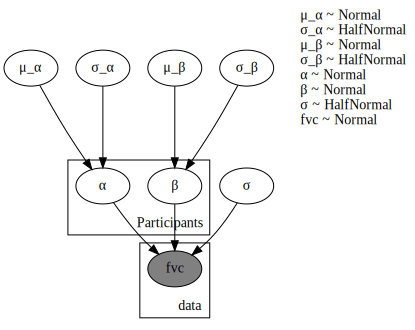

In [43]:
# Render the model graph


numpyro.render_model(model_2, model_kwargs=model_kwargs_train,
                render_distributions=True,
                render_params=True,
                )


In [44]:
model_kwargs_test = {"sample_weeks": x_test, "sample_patient_code": sample_patient_code_test, "sample_fvc": y_test}

In [45]:
nuts_final = NUTS(model_2)

mcmc_final = MCMC(nuts_final, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)

In [46]:
mcmc_final.run(rng_key, **model_kwargs_train)

sample: 100%|██████████| 6000/6000 [00:15<00:00, 397.91it/s, 63 steps of size 1.73e-02. acc. prob=0.85] 


In [47]:
predictive_final = Predictive(model_2, mcmc_final.get_samples())

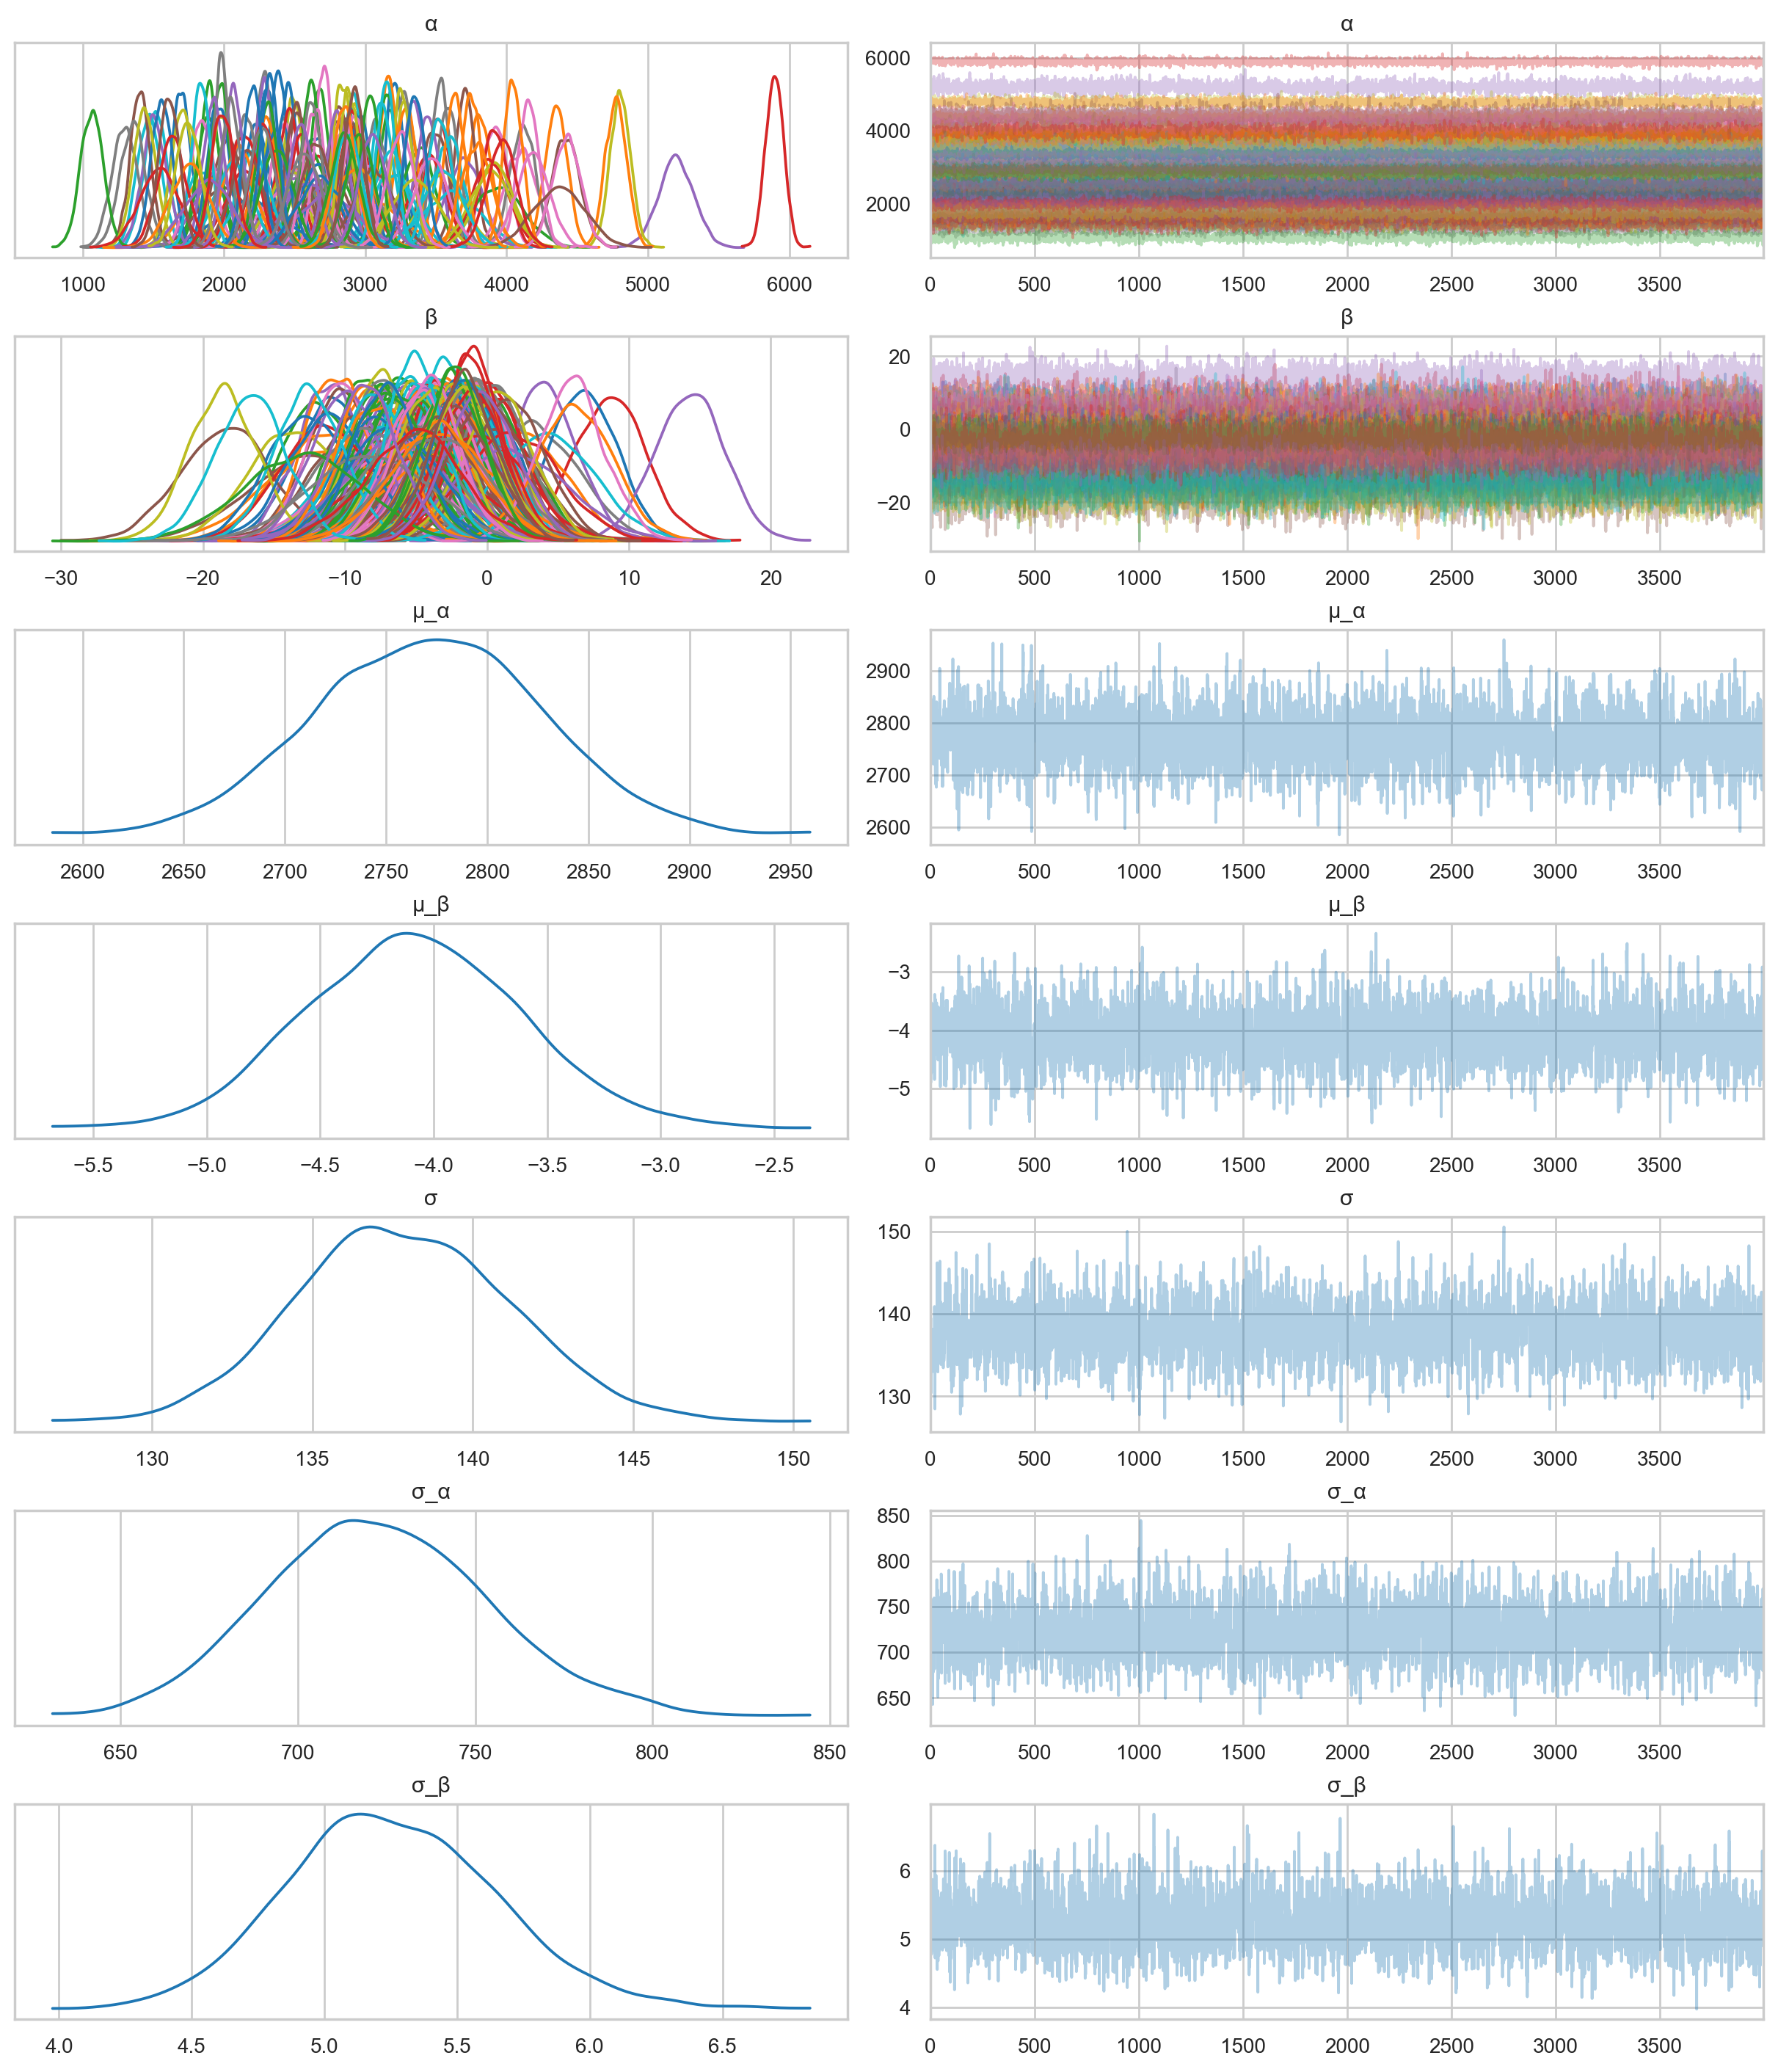

In [48]:
az.plot_trace(az.from_numpyro(mcmc_final), compact=True);

In [49]:
predictive_hierarchical = Predictive(model_2, mcmc_final.get_samples())

In [50]:
predictions_train_hierarchical = predictive_final(rng_key,
                                                         sample_weeks = model_kwargs_train["sample_weeks"],
                                                         sample_patient_code = model_kwargs_train["sample_patient_code"])['fvc']

mu_predictions_train_h = predictions_train_hierarchical.mean(axis=0)
std_predictions_train_h = predictions_train_hierarchical.std(axis=0)

maes["Hierarchical train"] = mean_absolute_error(y_train, mu_predictions_train_h)

In [51]:
maes

{'LinearRegression on train': 662.1236659544445,
 'LinearRegression on test': 626.3184730275215,
 'PooledModel on train': 661.24235853637,
 'PooledModel on test': 626.4491242439516,
 'Hierarchical train': 80.57488639283507}

In [52]:
predictions_test_hierarchical = predictive_final(rng_key,
                                                         sample_weeks = model_kwargs_test["sample_weeks"],
                                                         sample_patient_code = model_kwargs_test["sample_patient_code"])['fvc']

mu_predictions_test_h = predictions_test_hierarchical.mean(axis=0)
std_predictions_test_h = predictions_test_hierarchical.std(axis=0)

maes["Hierarchical test"] = mean_absolute_error(y_test, mu_predictions_test_h)

coverages["Hierarchical"] = coverage(y_test, mu_predictions_test_h, std_predictions_test_h).item()

print(maes)
print(coverages)

{'LinearRegression on train': 662.1236659544445, 'LinearRegression on test': 626.3184730275215, 'PooledModel on train': 661.24235853637, 'PooledModel on test': 626.4491242439516, 'Hierarchical train': 80.57488639283507, 'Hierarchical test': 110.49720419606855}
{'pooled coverage pooled model newer': 0.948387086391449, 'Hierarchical': 0.9387096762657166}


In [53]:
# Predict for a given patient

def predict_final(patient_code):
    predictions = predictive_final(rng_key, all_weeks, patient_code)
    mu = predictions["fvc"].mean(axis=0)
    sigma = predictions["fvc"].std(axis=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient_final(patient_code):
    mu, sigma = predict_final(patient_code)
    plt.plot(all_weeks, mu)
    plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform([patient_code])[0]
    #print(id_to_patient[0], patient_code)
    #print(patient_code, id_to_patient)
    patient_weeks = train[train["Patient"] == id_to_patient]["Weeks"]
    patient_fvc = train[train["Patient"] == id_to_patient]["FVC"]
    plt.scatter(patient_weeks, patient_fvc, alpha=0.5)
    #plt.scatter(sample_weeks[train["patient_code"] == patient_code.item()], fvc[train["patient_code"] == patient_code.item()], alpha=0.5)
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.title(patient_encoder.inverse_transform([patient_code])[0])

In [54]:
pd.Series(maes)

LinearRegression on train    662.123666
LinearRegression on test     626.318473
PooledModel on train         661.242359
PooledModel on test          626.449124
Hierarchical train            80.574886
Hierarchical test            110.497204
dtype: float64

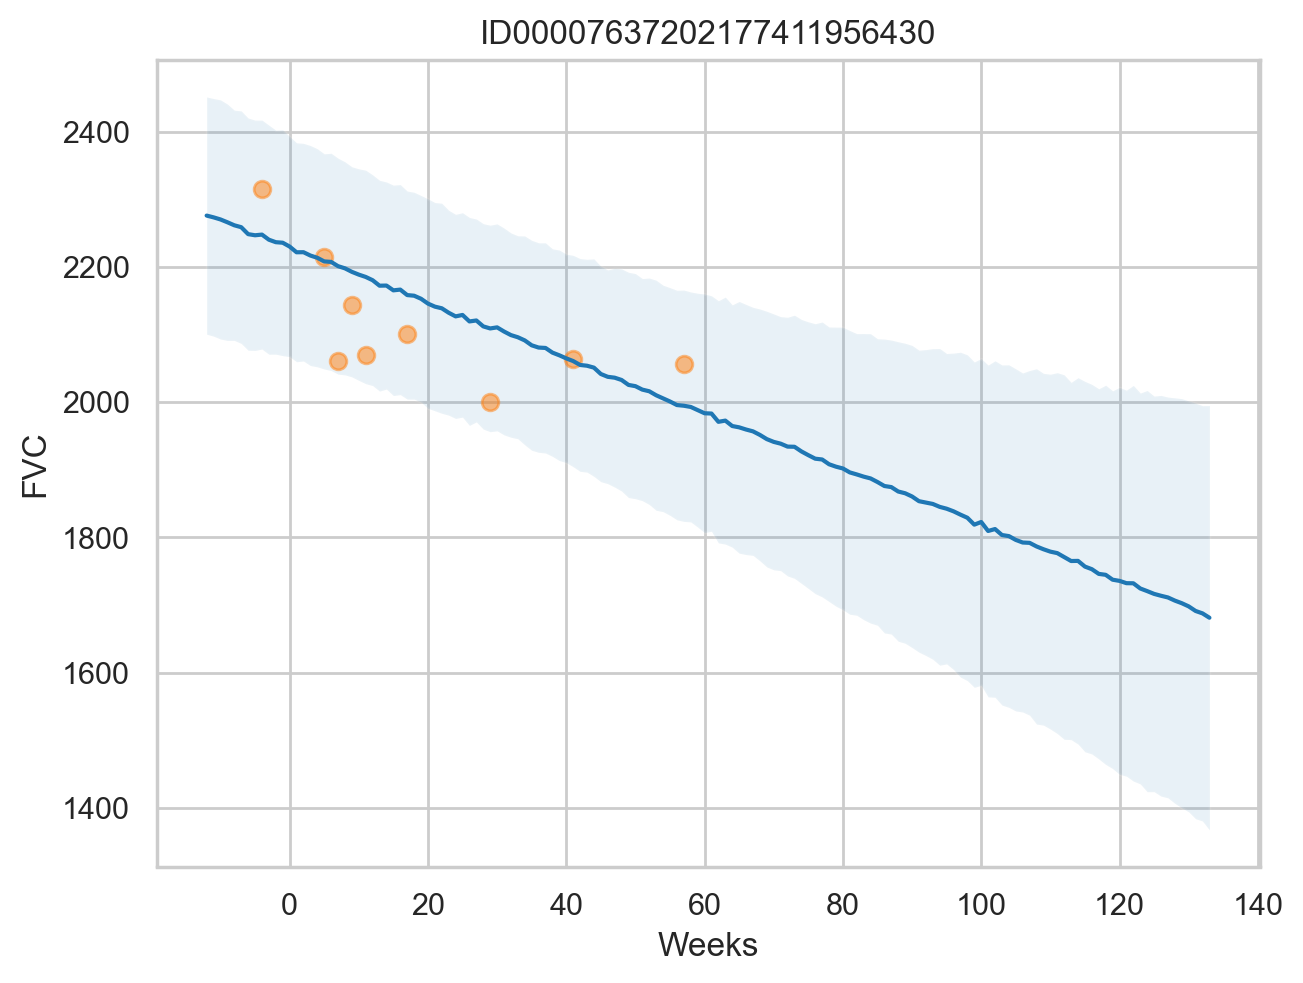

In [55]:
# plot for a given patient
plot_patient_final(np.array([0]))

### Partially pooled model with the sigma hyperpriors

In [56]:
### Hierarchical model

def model_3(sample_weeks, sample_patient_code, sample_fvc=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))
    𝛄_σ = numpyro.sample("𝛄_σ", dist.HalfNormal(30.0))
    n_patients = len(np.unique(sample_patient_code))

    with numpyro.plate("Participants", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))
        σ = numpyro.sample("σ", dist.Exponential(𝛄_σ))
    FVC_est = α[sample_patient_code] + β[sample_patient_code] * sample_weeks

    with numpyro.plate("data", len(sample_patient_code)):
        numpyro.sample("fvc", dist.Normal(FVC_est, σ[sample_patient_code]), obs=sample_fvc)

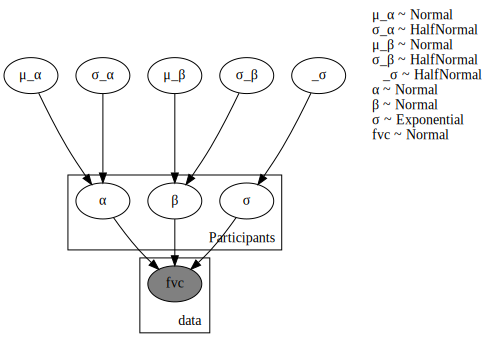

In [57]:
# Render the model graph


numpyro.render_model(model_3, model_kwargs=model_kwargs_train,
                render_distributions=True,
                render_params=True,
                )


In [58]:
nuts_kernel = NUTS(model_3)

mcmc_3 = MCMC(nuts_kernel, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)

In [59]:
mcmc_3.run(rng_key, **model_kwargs_train)

sample: 100%|██████████| 6000/6000 [00:26<00:00, 228.66it/s, 63 steps of size 5.69e-02. acc. prob=0.87] 


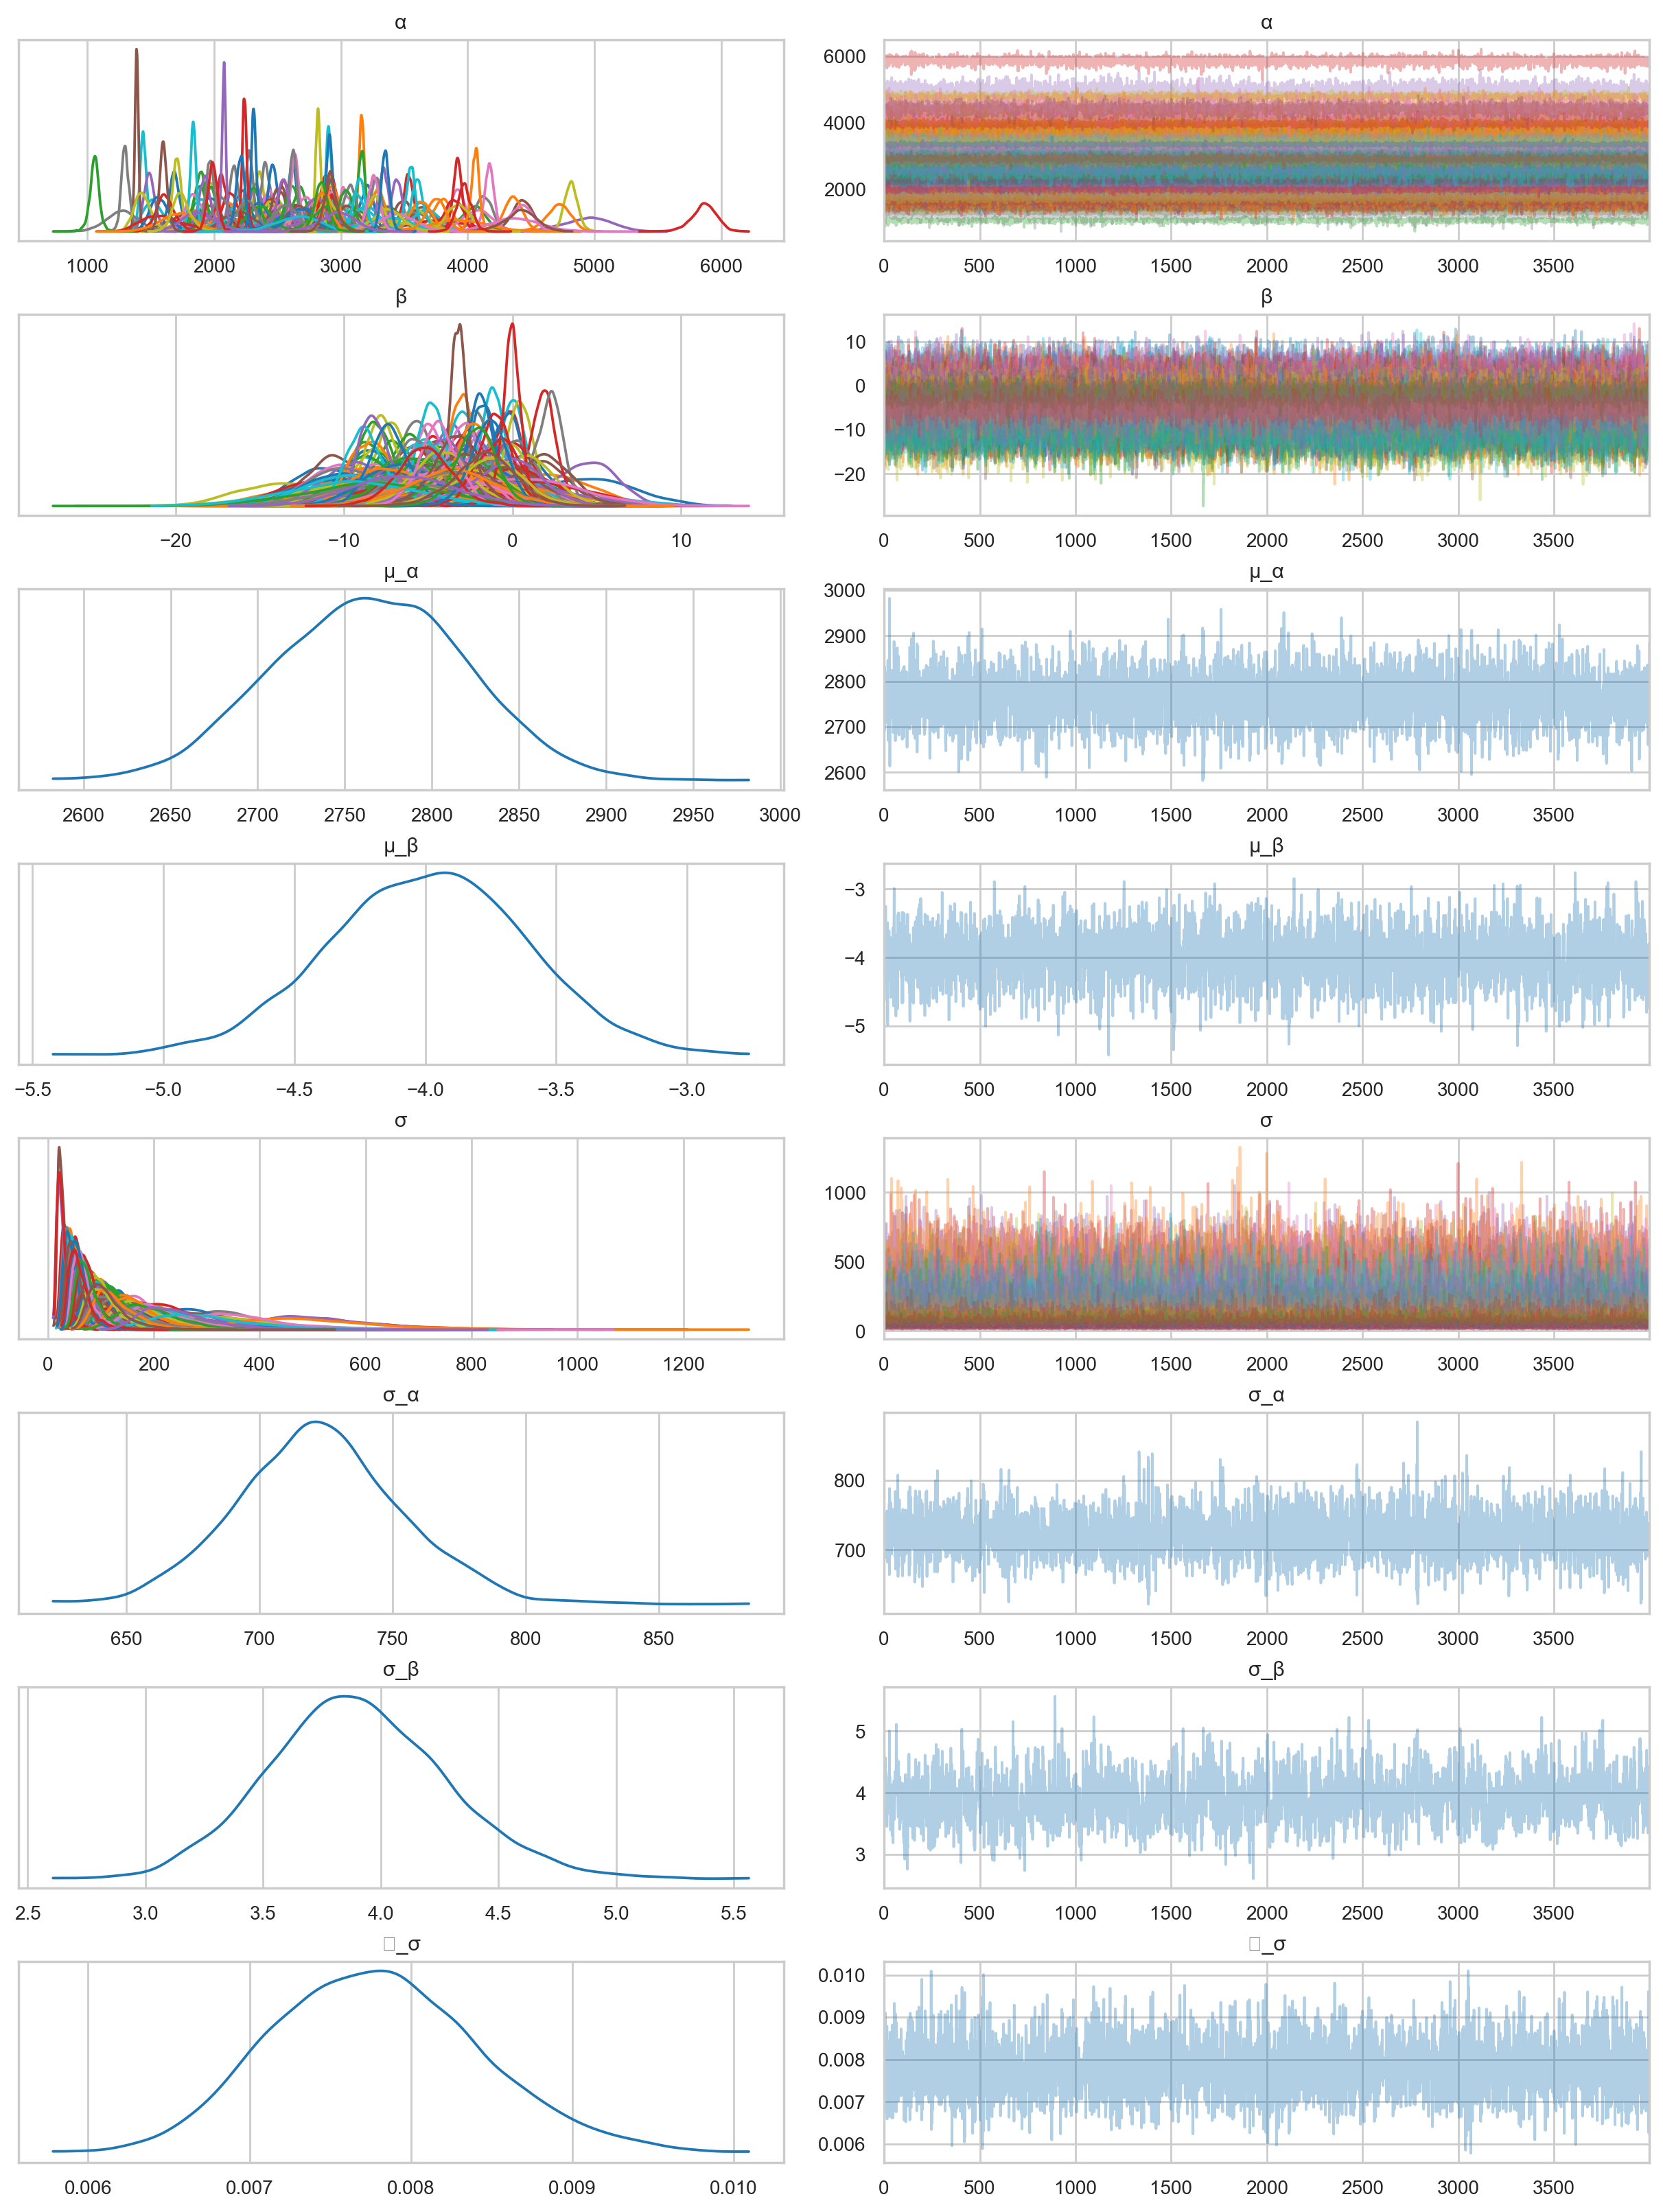

In [60]:
az.plot_trace(az.from_numpyro(mcmc_3), compact=True);

In [61]:
predictive = Predictive(model_3, mcmc_3.get_samples())

In [62]:
predictive_train_3 = predictive(rng_key,sample_weeks = model_kwargs_train["sample_weeks"],sample_patient_code = model_kwargs_train["sample_patient_code"])['fvc']

mu_predictions_train_3 = predictive_train_3.mean(axis=0)
std_predictions_train_3 = predictive_train_3.std(axis=0)

maes["model_3 train"] = mean_absolute_error(y_train, mu_predictions_train_3)

In [63]:
predictive_test_3 = predictive(rng_key,sample_weeks = model_kwargs_test["sample_weeks"],sample_patient_code = model_kwargs_test["sample_patient_code"])['fvc']

mu_predictions_test_3 = predictive_test_3.mean(axis=0)
std_predictions_test_3 = predictive_test_3.std(axis=0)

maes["model_3 test"] = mean_absolute_error(y_test, mu_predictions_test_3)

In [64]:
pd.Series(maes)

LinearRegression on train    662.123666
LinearRegression on test     626.318473
PooledModel on train         661.242359
PooledModel on test          626.449124
Hierarchical train            80.574886
Hierarchical test            110.497204
model_3 train                 85.884296
model_3 test                 111.439091
dtype: float64

In [65]:
# Predict for a given patient
def predict_final_3(patient_code):
    predictions = predictive(rng_key, all_weeks, patient_code)
    mu = predictions["fvc"].mean(axis=0)
    sigma = predictions["fvc"].std(axis=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient_final_3(patient_code):
    mu, sigma = predict_final_3(patient_code)
    plt.plot(all_weeks, mu)
    plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform([patient_code])[0]
    #print(id_to_patient[0], patient_code)
    #print(patient_code, id_to_patient)
    patient_weeks = train[train["Patient"] == id_to_patient]["Weeks"]
    patient_fvc = train[train["Patient"] == id_to_patient]["FVC"]
    plt.scatter(patient_weeks, patient_fvc, alpha=0.5)
    #plt.scatter(sample_weeks[train["patient_code"] == patient_code.item()], fvc[train["patient_code"] == patient_code.item()], alpha=0.5)
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.title(patient_encoder.inverse_transform([patient_code])[0])

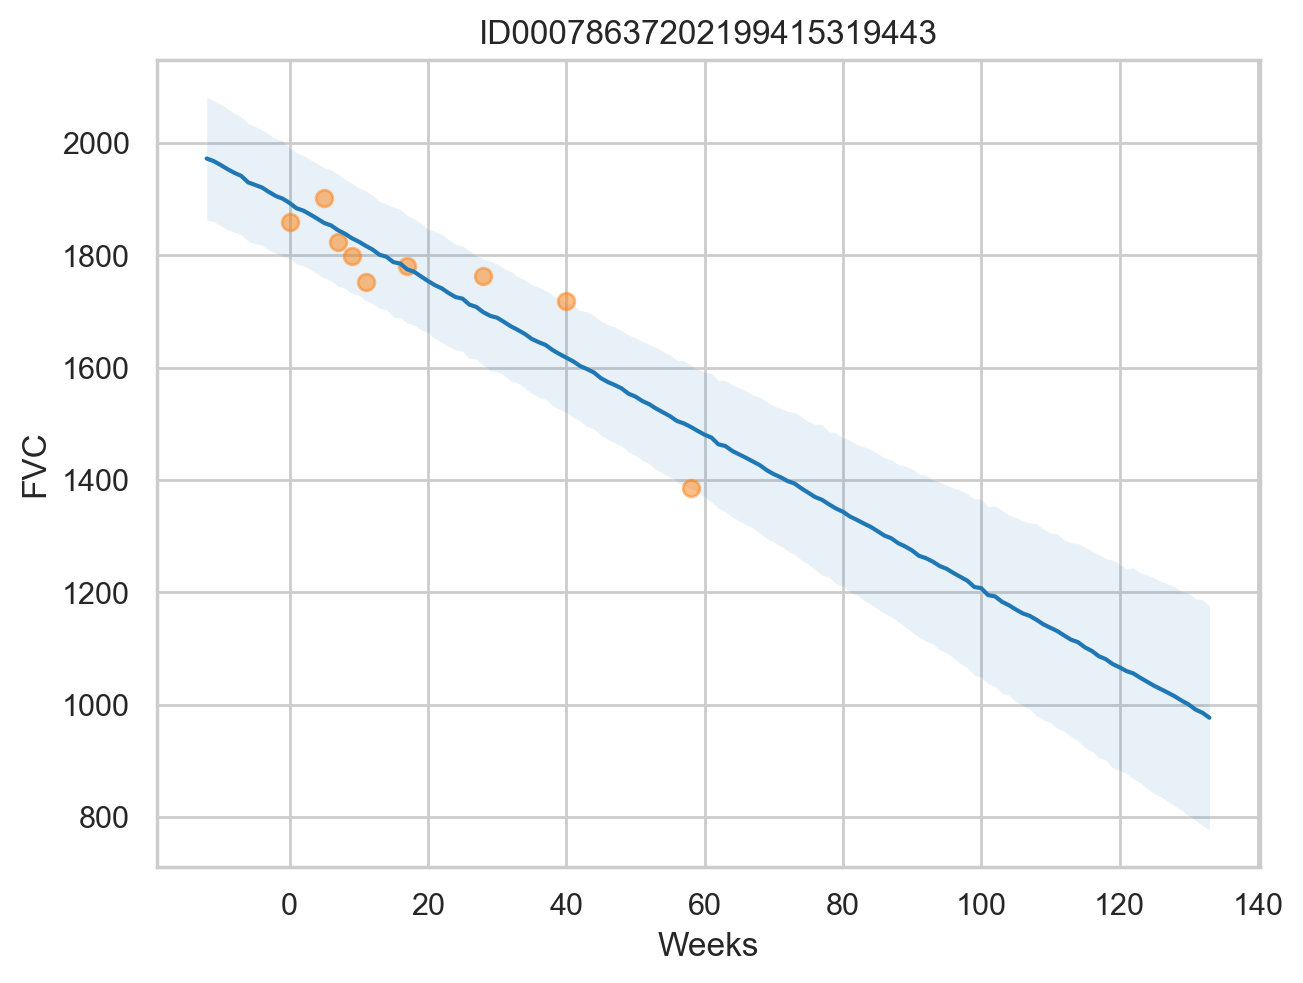

In [66]:
# plot for a given patient
plot_patient_final_3(np.array([32]))

# Question 3

Done in other notebooks that are attached

# Question 4

In [69]:
# import torch, numpy and matplotlib
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as D
import hamiltorch
torch.set_printoptions(sci_mode=False)
import emcee

##### Prior is assumed to be uniform, as nothing is given in the question about it.
##### Sampling from log likelihood would be equivalent to sampling from the posterior.

In [70]:
def log_likelihood(omega):
    if type(omega) != torch.Tensor:
        omega = torch.tensor(omega)
    mean = torch.tensor([0., 0.])
    stddev = torch.tensor([0.5, 1.])
    return D.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

In [71]:
actual_mean = torch.tensor([0., 0.])
actual_stddev = torch.diag(torch.tensor([0.5, 1.]))**2

## MH Algorithm Scratch

In [72]:
def get_MH_samples_scratch (initial_sample, burn_samples, total_samples, sigma, stddev):
    count = 0
    x_t = initial_sample
    stddev = sigma*stddev
    samples = []
    for i in range(total_samples):
        x_new = D.MultivariateNormal(x_t, stddev).sample()
        alpha = torch.exp(log_likelihood(x_new) - log_likelihood(x_t))
        if (alpha>1):
            if (i>burn_samples):
                count += 1
            x_t = x_new
            samples.append(x_t)
        else:
            u = D.uniform.Uniform(0, 1).sample()
            if (u < alpha):
                if (i>burn_samples):
                    count += 1
                x_t = x_new
                samples.append(x_t)
            else:
                samples.append(x_t)
    
    return samples, count/(total_samples-burn_samples)

In [73]:
burn_samples = 500
total_samples = 1500
initial_sample = torch.tensor([0.25 ,0.25])
sigma = 0.5
stddev = torch.diag(torch.tensor([1., 1.]))

In [74]:
samples, ar = get_MH_samples_scratch(initial_sample = initial_sample, burn_samples = burn_samples, total_samples = total_samples, sigma = sigma, stddev = stddev)

In [75]:
actual_samples = samples[burn_samples:]

In [76]:
def get_mean_cov_of_samples (samples):
    samples = torch.stack(samples)
    mean = torch.mean(samples, dim=0)
    cov = torch.cov(samples.T)
    return mean, cov

##### Mean and Cov are close to actual values

In [77]:
mean_scratch, cov_scratch = get_mean_cov_of_samples(actual_samples)
print("Mean and Covariance from scratch: \n", mean_scratch, "\n", cov_scratch)

Mean and Covariance from scratch: 
 tensor([0.0168, 0.0322]) 
 tensor([[0.2489, 0.0454],
        [0.0454, 1.1654]])


##### Relation Between acceptance ratio and sigma

In [78]:
def get_acceptance_rate (sigma):
    samples, ar =  get_MH_samples_scratch(initial_sample = initial_sample, burn_samples = burn_samples, total_samples = total_samples, sigma = sigma, stddev = stddev)
    return ar

Text(0.5, 1.0, 'Acceptance Rate vs Sigma')

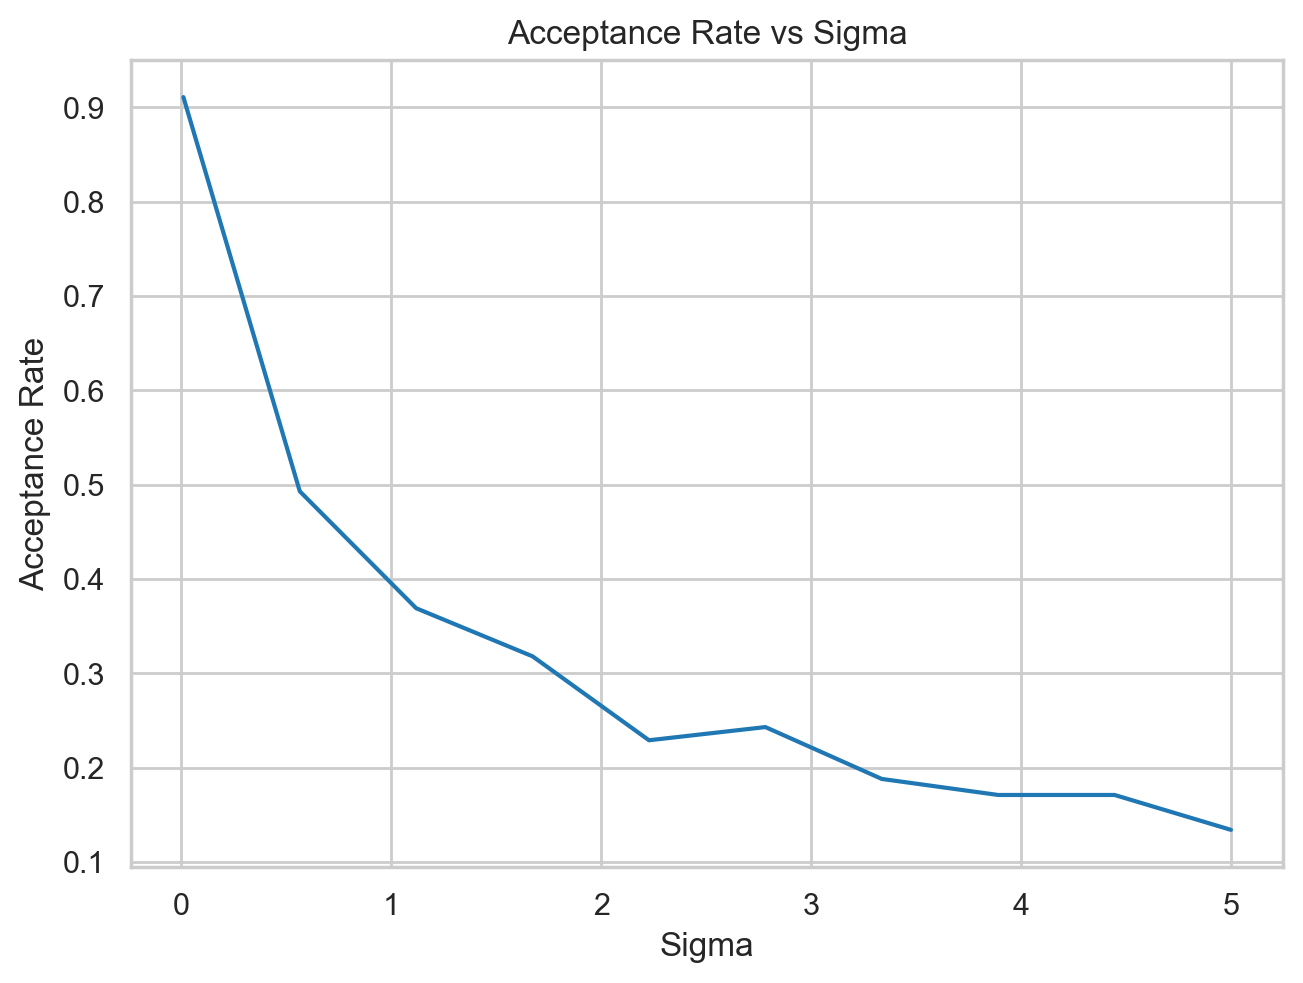

In [79]:
x = np.linspace(0.01, 5, 10)
y = [get_acceptance_rate(i) for i in x]
plt.plot(x, y)
plt.xlabel("Sigma")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rate vs Sigma")

## Hamiltorch HMC

In [80]:
samples_hmc = hamiltorch.sample(log_prob_func=log_likelihood, params_init=initial_sample, num_samples = total_samples)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 1500/1500 | 147.01       
Acceptance Rate 1.00


In [81]:
actual_samples_hmc = samples_hmc[burn_samples:]
mean_hmc, cov_hmc = get_mean_cov_of_samples(actual_samples_hmc)
print("Mean and Covariance from HMC: \n", mean_hmc, "\n", cov_hmc)

Mean and Covariance from HMC: 
 tensor([0.0004, 0.0059]) 
 tensor([[ 0.2360, -0.0010],
        [-0.0010,  0.9578]])


## EMCEE 

In [82]:
nwalkers = 10
ndim = 2
nsteps = 750
burnin = 500
initial_positions = np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
sampler.run_mcmc(initial_positions, nsteps)
samples = sampler.chain[:, burnin:, :].reshape(-1, ndim)

In [83]:
actual_samples_emcee = list(map(torch.tensor, samples.tolist()))
mean_emcee, cov_emcee = get_mean_cov_of_samples(actual_samples_emcee)
print("Mean and Covariance from EMCEE: \n", mean_emcee, "\n", cov_emcee)

Mean and Covariance from EMCEE: 
 tensor([-0.0880,  0.2168]) 
 tensor([[0.2301, 0.0337],
        [0.0337, 0.8620]])
